(sensitivity-details-section)=
# More on Function Sensitivity

In the Laplace mechanism, we saw that the noise added was proportional to the sensitivity of the query function. 

$M(D, \epsilon, \Delta) = f(D)+L(\frac{\Delta}{\epsilon})$

Roughly, the sensitivity of a function reflects the amount the function’s output will change when its input dataset changes by one record. Why we need sensitivity to be considered when adding noise to query result?

Intuitively, we need to hide how much a single record can change the output to hide the fact that the record belongs to the dataset, which in turn keeps participation of the person (or entity) in the dataset a secret. Consequently, the noise needs to be higher if the sensitivity is higher! But since DP guarantee holds for all possible datasets (not just the dataset we actually have), knowing a function's sensitivity without seeing all possible datasets is often challenging.

---
**Definitions**

Global sensitivity: For two neighboring datasets $D_1$ and $D_2$, the global sensitivity is defined as 
$GS = max_{D_1, D_2; |D_1,D_2|\leq 1} |f(D_1) - f(D_2)|$

which is just the abosolute difference of the outputs of query function $f$ applied to the two datasets. ). This measure of sensitivity is called *global* because it does not depend on the actual dataset being queried.

Local sensitivity: It is the same as global sensitivity, except that one of the datasets is the one being queried.

Most of the time, sensitivity refers to global sensitivity. Next we will look at some examples of computing sensitivity for a given query function.

---

## Counting queries
Counting queries returns the number of rows in the dataset which satisfy one or more conditions. Generally, such queries  have a sensitivity of 1, since adding one row can contribute to the count by at most 1: either this row is included in the count (when it satisfied the conidtions), increasing the count by 1, or not, when the count stays the same.  Similarly, deleting a row can decrease the count by at most 1.

In [35]:
import pandas as pd
import numpy as np
adult = pd.read_csv('../../datasets/adult_with_pii.csv')

## Example query: how many people have studied 11th grade?
print("Count:", adult[adult['Education']=="11th"].shape[0])

## Example query: how many people named Dorry Potter have studied 11th grade?
print("Count:", adult[(adult['Education']=="11th") & (adult['Name']=="Dorry Poter")].shape[0])

Count: 1175
Count: 1


## Summation and Average queries

Summation queries adds up the values in a specific column of the datbase. For example, the query "What is the total work hours of people who work as a tech support?" sums the hours per week column for rows that satisfy the condition (i.e., working as tech support.

In [41]:
#Query: total number of working hours per week for Tech-support people
adult[adult.Occupation=='Tech-support']["Hours per week"].sum()

36593

How can we calculate the sensitivity of this function? For this, we will have to know what can be the maximum possible work hours. In the absence of this knowledge, we might make reasonable guesses, in this case, it is not difficult. Since 40 hours per week is the accepted norm, we can set this as the sensitivity (or a slightly larger value to be safe). But in many other cases, estimating a reasonable upper limit is not straightforward (salary, for example).

Similarly, average queries return the mean value of some column for rows that meet certain conditions.

In [42]:
#Query: average number of working hours per week for Tech-support people
adult[adult.Occupation=='Tech-support']["Hours per week"].mean()

39.432112068965516

Similar to summation, it is difficult to know the sensitivity of the average query without knowing all possible datasets. However, the average query can be expressed as a summation query and a count query, because the average is the sum divided by the count.

In [43]:
#average qurey as sum and count query
adult[adult.Occupation=='Tech-support']["Hours per week"].sum()/adult[adult.Occupation=='Tech-support']["Hours per week"].count()

39.432112068965516

Since count queries have sensitivity 1, we just need to figure out the sensitivity of the sum query.

But, in general, summation queries (and thus average queries) have unbounded sensitivity when no lower and upper bounds exist on the value of the attribute being summed. When lower and upper bounds do exist, the sensitivity of a summation query is equal to the difference between them. One way to make a bound is to artificially set a lower and an upper limit of values, a process called clipping.

For example, we can set the limits for working hours to be (0, 60), since no one can work less than 0 hours, and 60 is a reasonable upper limit. 

One good rule of thumb might be set the limits observed at the current dataset. But, **if we *look* at the actual values in the dataset, this might violate differential privacy**. One workaround is to use differentially private queries to estimate the lower and upper limits---use DP to achieve DP! In the case of working hours, we can set the lower bound to 0 and slowly increase the upper bound until the query result stops changing, i.e., no new row was added by increasing the bound. Let's try this with Laplace mechanism with privacy budget $\epsilon =.1$


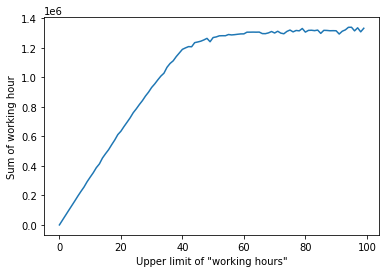

In [79]:
import matplotlib.pylab as plt
epsilon =.01
lower_limit=0
upper_lim=range(0,100)
sum_hours=[]
for u in upper_lim:
        s = adult["Hours per week"].clip(lower_limit, u).sum() + \
        np.random.laplace(loc=0, scale= (u-lower_limit)/epsilon)
        sum_hours.append(s)
plt.plot(upper_lim, sum_hours)
plt.xlabel('Upper limit of "working hours"')
plt.ylabel('Sum of working hour')
#plt.yscale('log')
plt.show()

From the figure, it is pretty clear that the result does not change much after 50, which can be a reasonable upper bound (in the dataset, 75% rows have values less than 45, see below)

In [82]:
adult["Hours per week"].describe()

count    32563.000000
mean        40.436201
std         12.349083
min          0.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: Hours per week, dtype: float64

Note that, since we are quering 100 times to draw that plot, we are spending .1 privacy budget in total (one query spends .01). This is discussed in detail in the chapter on sequential composition.

### Bounded and Unbounded DP